# Reparametrization test
In which cases model reparametrization is useful?

In [2]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.05' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local


gpu [cuda(id=0)]


## Define and reparametrize model

2024-04-02 12:37:23.905548: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


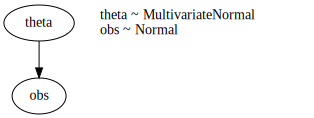

In [2]:
def model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    theta = sample('theta', dist.MultivariateNormal(loc=mean, covariance_matrix=covar))
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

from numpyro.infer.util import log_density
logp_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta': xxyy_ij,
                                                'obs': obs},)[0]
logp_vfn = jit(vmap(vmap(logp_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=model,
    render_distributions=True,
    render_params=True,)

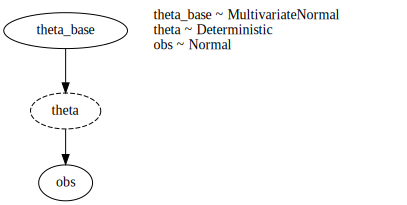

In [3]:
def reparam_model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    dim = len(mean)
    theta_base = sample('theta_base', dist.MultivariateNormal(loc=jnp.zeros(dim), covariance_matrix=jnp.eye(dim)))
    L = jax.scipy.linalg.cholesky(covar)
    theta = deterministic('theta', L @ theta_base + mean)
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

logp_rep_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=reparam_model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta_base': xxyy_ij,
                                                'obs': obs},)[0]
logp_rep_vfn = jit(vmap(vmap(logp_rep_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=reparam_model,
    render_distributions=True,
    render_params=True,)

## Show posteriors

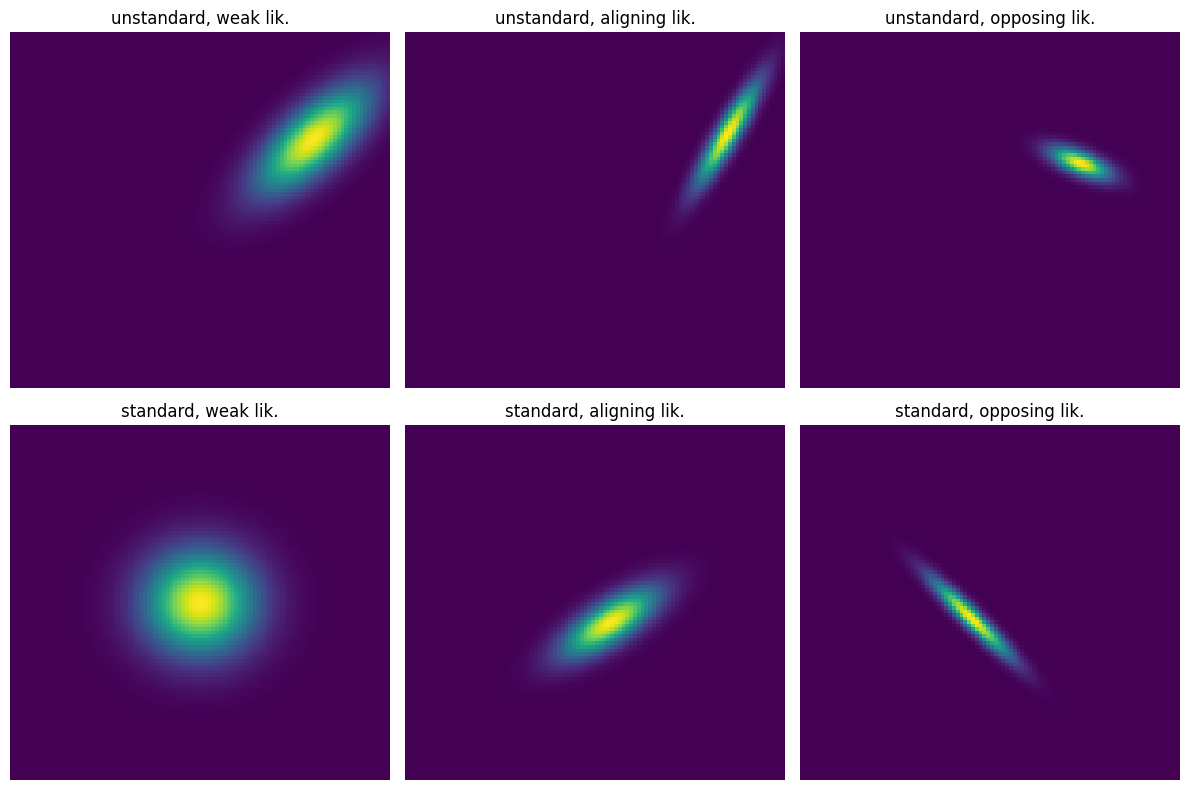

: 

In [11]:
angle = jnp.pi/4
model_kwargs = {'mean':jnp.array([2,3]), 
                'covar':jnp.array([[1,jnp.cos(angle)],[jnp.cos(angle),1]]),}

box_corner = 5
n_discr = 100
box = np.array([[-box_corner, box_corner], [-box_corner, box_corner]])
xxyy = np.mgrid[[slice(box_ax[0],box_ax[1],n_discr*1j) 
                       for box_ax in box]]

axis_switch = "off"
obs = 5
plt.figure(figsize=(12,8))
model_kwargs['epsilon'] = 10
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(231)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, weak lik."), plt.axis(axis_switch)
plt.subplot(234)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, weak lik."), plt.axis(axis_switch)

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(232)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, aligning lik."), plt.axis(axis_switch)
plt.subplot(235)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, aligning lik."), plt.axis(axis_switch)

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([2,1])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(233)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, opposing lik."), plt.axis(axis_switch)
plt.subplot(236)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, opposing lik."), plt.axis(axis_switch)
plt.tight_layout()
plt.savefig('standunstand_param.png', dpi=200, bbox_inches='tight')
plt.show()

## Conclusion
* In the case of a model where the parameters are equally constrained, i.e. the likelihood is aligned with the prior, then it is better to reparametrize.
* In the case of a model where the likelihood constrain parameters unequally, it can sometimes be better not to reparametrize.

## Tanh reparam

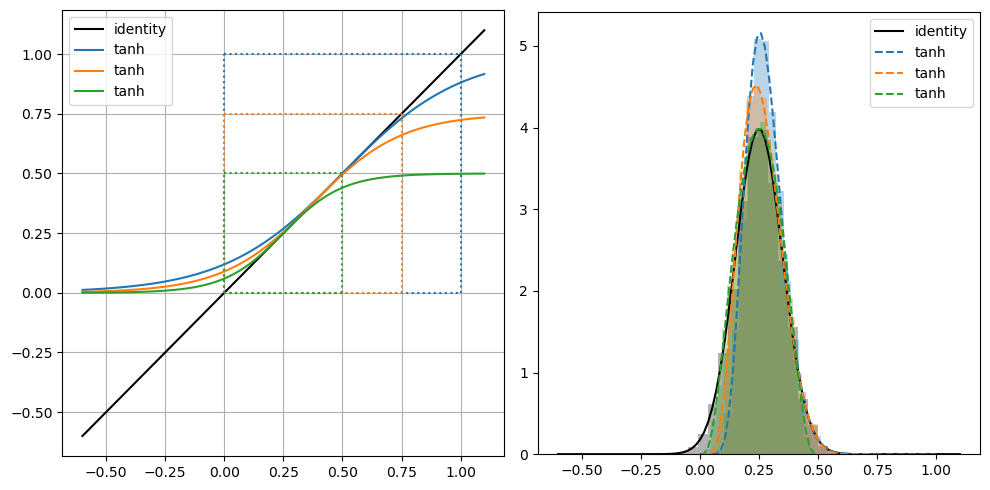

In [4]:
from scipy.stats import norm
from functools import partial

def tanh_push(x, a, b):
    m, d = (b+a)/2, (b-a)/2
    return d * jnp.tanh( (x-m)/d ) + m

def invtanh_push(y, a, b):
    m, d = (b+a)/2, (b-a)/2
    return d * jnp.arctanh( (y-m)/d ) + m

def pdf_tanh_push(pdf, y, a, b):
    grad_fn = vmap(grad(partial(tanh_push, a=a, b=b)))
    x = invtanh_push(y, a, b)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = 0.25, 0.1
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = norm.rvs(mean, std, size=10000)
intervals = [[0, 1], [0,0.75], [0,0.5]]

x = jnp.linspace(-0.6,1.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(x, x, color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    plt.plot(x, tanh_push(x, a, b), color=color[i+1], label="tanh")
    plt.hlines([a,b], a, b, color=color[i+1], linestyles=':')
    plt.vlines([a,b], a, b, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(x, pdf_fn(x), color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    plt.hist(tanh_push(samples, a, b), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(x, pdf_tanh_push(pdf_fn, x, a, b), '--', color=color[i+1], label="tanh")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

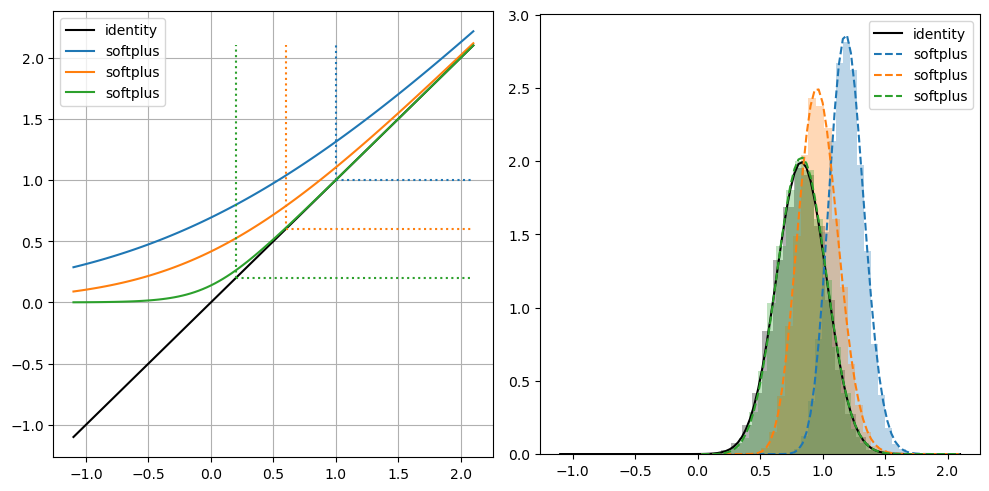

In [5]:
from scipy.stats import norm
from functools import partial

def softplus_push(x, s):
    return jnp.log(jnp.exp(x / s) + 1) * s

def invsoftplus_push(y, s):
    return jnp.log(jnp.exp(y / s) - 1) * s

def pdf_softplus_push(pdf, y, s):
    grad_fn = vmap(grad(partial(softplus_push, s=s)))
    x = invsoftplus_push(y, s)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = 0.831, 0.2
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = norm.rvs(mean, std, size=10000)
softness = [1, 0.6, 0.2]
# softness = [1, 2/3, 1/3]

x = jnp.linspace(-1.1,2.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(x, x, color=color[0], label="identity")
for i, s in enumerate(softness):
    plt.plot(x, softplus_push(x, s), color=color[i+1], label="softplus")
    xmax = x.max()
    plt.hlines([s], s, xmax, color=color[i+1], linestyles=':')
    plt.vlines([s], s, xmax, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(x, pdf_fn(x), color=color[0], label="identity")
for i, s in enumerate(softness):
    plt.hist(softplus_push(samples, s), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(x, pdf_softplus_push(pdf_fn, x, s), '--', color=color[i+1], label="softplus")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()